# Dataset: layer-cluster graph approach

Full LC level dataset. Input for object condensation.
Supply all nodes, trackster assignment info and trackster edges.
Trackster edges are based on candidates from the cone neighbourhood (within a couple of detector layers).

In [1]:
import uproot
import numpy as np
import awkward as ak
import networkx as nx

import matplotlib.pyplot as plt

from reco.distance import get_z_map, apply_map
from reco.event import get_candidate_pairs_little_big
from reco.graphs import create_graph
from reco.matching import find_good_pairs_direct

from reco.plotting import plot_graph_3D

data_root = "data"
ds_name = "MultiParticle"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15163313_1.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = "/mnt/ceph/users/ecuba/{ds_name}/"
# file_name = f"{raw_dir}/new_ntuples_14992862_1293.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

z_map = get_z_map(data_root)

In [2]:
eid = 0

vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
vi = tracksters["vertices_indexes"].array()[eid]

clouds = [np.array([vx[tid], vy[tid], apply_map(vz[tid], z_map, factor=2)]).T for tid in range(len(vx))]

raw_energy = tracksters["raw_energy"].array()[eid]
sim2reco_indices = np.array(associations["tsCLUE3D_simToReco_SC"].array()[eid])
sim2reco_shared_energy = np.array(associations["tsCLUE3D_simToReco_SC_sharedE"].array()[eid])
inners = graphs["linked_inners"].array()[eid]

In [3]:
c_pairs, dst_map = get_candidate_pairs_little_big(clouds, inners, raw_energy, max_distance=10, energy_threshold=10)
c_matches = find_good_pairs_direct(sim2reco_indices, sim2reco_shared_energy, raw_energy, c_pairs)

positive = list(c_matches)
negative = list(set(c_pairs) - c_matches)

print(f"Positive: {len(positive)}, negative: {len(negative)}")

Positive: 36, negative: 168


Nodes: 952, edges: 1122, positive: 21


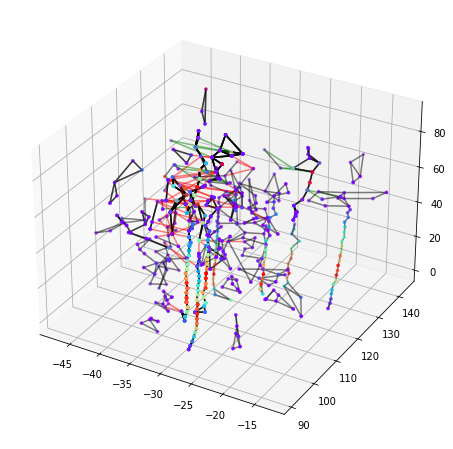

In [4]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

np.random.seed(42)
node_mix = positive + negative
np.random.shuffle(node_mix)

nodes = 0
edges = 0
contained = 0

for (ca, cb) in node_mix[:50]:
    ca_lc = set(vi[ca])
    cb_lc = set(vi[cb])

    cvx = ak.flatten([vx[ca], vx[cb]])
    cvy = ak.flatten([vy[ca], vy[cb]])
    cvz = ak.flatten([vz[ca], vz[cb]])
    cve = ak.flatten([ve[ca], ve[cb]])
    cvi = ak.flatten([vi[ca], vi[cb]])

    G = create_graph(cvx, cvy, apply_map(cvz, z_map, factor=2), cve, trk_lc_index=cvi, N=2, higher_e=False)

    for edge in G.edges:
        a, b = edge
        ai = G.nodes[a]["index"]
        bi = G.nodes[b]["index"]
        if (ai in ca_lc and bi in cb_lc) or (bi in ca_lc and ai in cb_lc):
            if (ca, cb) in c_matches:
                G.edges[edge]["color"] = "green"
                contained += 1
            else:
                G.edges[edge]["color"] = "red"

    plot_graph_3D(G, cve, ax=ax, s=10)
    nodes += len(cvx)
    edges += len(G.edges)

print(f"Nodes: {nodes}, edges: {edges}, positive: {contained}")


Working on trackster-level is nice, but we want to utilize the LC information somehow:

Options
- some kind of embedding encoding the geometrical properties
    - point cloud embeddings?
    - TODO: read up - gut feeling - full network would be better
- full network on LC
    - predictiong the share of cut edges between tracksters using some k-nn
    - cons: lots of edges, huge graphs
- object condensation
    - actual object condensation (hits-tracksters):
        - using clue3D info as a feature?
        - how to have ground truth - would be nice to keep the tracksters intact
    - partial object condensation
        - using clue3D info to condensate after running edgeconv
        - how would the training work here?
        - do we allow connections between tracksters?
        - LC -> edgeconv -> pooling / condensation -> edgeconv -> link prediction


##  Object condensation

input data:
- tracksters
    - layer-clusters (x, y, z, e)
    - lc to trackster assigment
- trackster-edge-list
- labels for trackster-edge-list

edgeconv:
- either only within a trackster using the lc to trackster assigment
- or withing a neighbourhood and then collapsing based on the lc to trackster assigment

In [5]:
from reco.dataset import PointCloudSet

In [6]:
ds = PointCloudSet(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=1,
)
ds

Processing...
/Users/ecuba/data/MultiParticle/new_ntuples_15163313_4.root
Done!


PointCloudSet(graphs=100, nodes=100895, edges=32294, max_distance=10, energy_threshold=10)